# Mammogram Mass prediction

## Predict whether a mammogram mass is benign or malignant


**- - - A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.- - - **


The dataset is "mammographic masses", a public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so it will be discarded in this analysis. The age, shape, margin, and density attributes are the features that I will build my model with, and "severity" is the classification I will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.



## The analysis

To apply several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy. Methods such as Classification Reports, Confusion Matrices and Accuracy Scores are also used, but the decisive one will be a measure with K-Fold cross validation (K=10). Applying:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* A neural network using Keras.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Preparing the data

The mammographic_masses.data.txt file is uploaded into a Pandas dataframe.

In [2]:
input_file = "C:/Users/jangn/CODE/Sundog_DataScience/DataScience/DataScience-Python3/data_sets/FinalProject_MammographicMasses/mammographic_masses.data.txt"

df = pd.read_csv(input_file, names = ["BI_RADS", "Age", "Shape", "Margin", "Density", "Severity"], na_values=["?"])
# added na_values=["?"] to replace ?'s with NaN
df.head(5)

,BI_RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [3]:
df.describe()

,BI_RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.295099,55.487448,2.721505,2.796276,2.910734,0.463059
std,0.704509,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,4.000000,1.000000


The feature BI_RADS is droppedn since it will not be used in the model.

In [4]:
df.drop(['BI_RADS'], axis=1)
df.corr()

,BI_RADS,Age,Shape,Margin,Density,Severity
BI_RADS,1.000000,0.290454,0.406678,0.413853,0.086319,0.504815
Age,0.290454,1.000000,0.364077,0.411355,0.028954,0.432066
Shape,0.406678,0.364077,1.000000,0.742211,0.078666,0.563308
Margin,0.413853,0.411355,0.742211,1.000000,0.109392,0.574919
Density,0.086319,0.028954,0.078666,0.109392,1.000000,0.064010
Severity,0.504815,0.432066,0.563308,0.574919,0.064010,1.000000


There are quite a few missing values in the data set. Let's view the data graphically. Does there appear to be any sort of correlation to what sort of data has missing fields? 

<function matplotlib.pyplot.show>

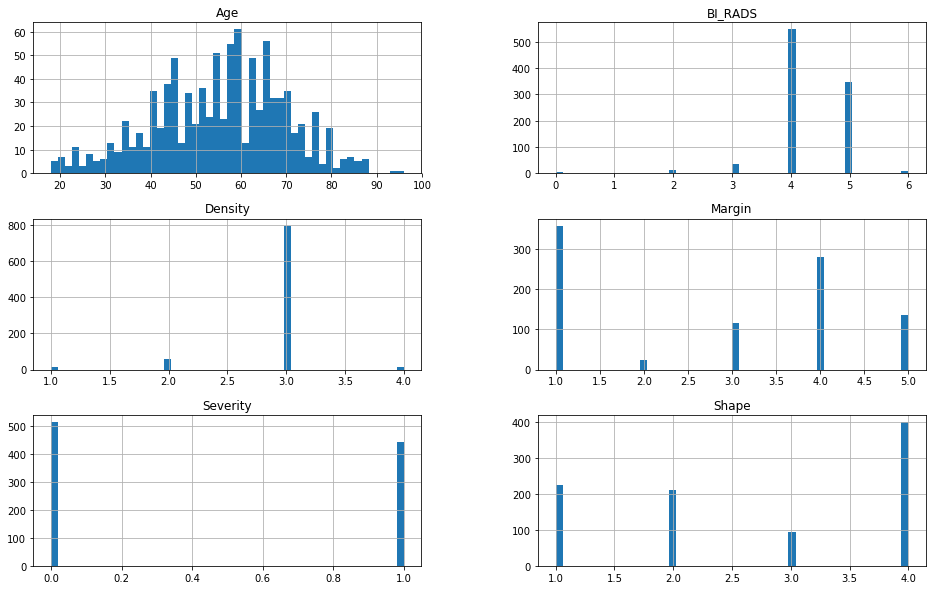

In [5]:
df.hist(bins=50, figsize= (16,10))
plt.show

Except for Density the features are quite evenly distributed so we could just drop the rows with missing. But instead I'll replace them with their means to have as much data available as possible.

### Missing values are replaced by their means.

In [6]:
df['BI_RADS'].fillna(4.277134, inplace=True) #NOT REALLY NECESSARY SINCE BI-RADS ISN'T USED!
df['Age'].fillna(55.416490, inplace=True)
df['Shape'].fillna(2.721505, inplace=True)
df['Margin'].fillna(2.792035, inplace=True)
df['Density'].fillna(2.908571, inplace=True)
#PLEASE NOTE! Could use   sklearn.preprocessing.Imputer()   also!

In [7]:
df.describe()

,BI_RADS,Age,Shape,Margin,Density,Severity
count,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,4.295062,55.487079,2.721505,2.796064,2.910563,0.463059
std,0.703775,14.442374,1.222561,1.526880,0.365075,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,6.000000,96.000000,4.000000,5.000000,4.000000,1.000000


Next the Pandas dataframes are converted into numpy arrays that can be used by scikit_learn. One array that extracts only the feature data to work with (age, shape, margin, and density) and another array that contains the classes (severity). There will also need to be an array of the feature name labels.

In [8]:
X = df.drop(['Severity', 'BI_RADS'], axis=1)
y = df['Severity']
features = ['Age', 'Shape', 'Margin', 'Density']
X_array = X.as_matrix() # creating an array
y_array = y.as_matrix() # creating an array

### First Scale the features

Most machine learning models require the input data to be normalized, so the attribute data is normalized. 

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)

scaled_data = scaler.transform(X) # normalizes/scales the entire data, not only train

Looking at the difference graphically the change is apparent!

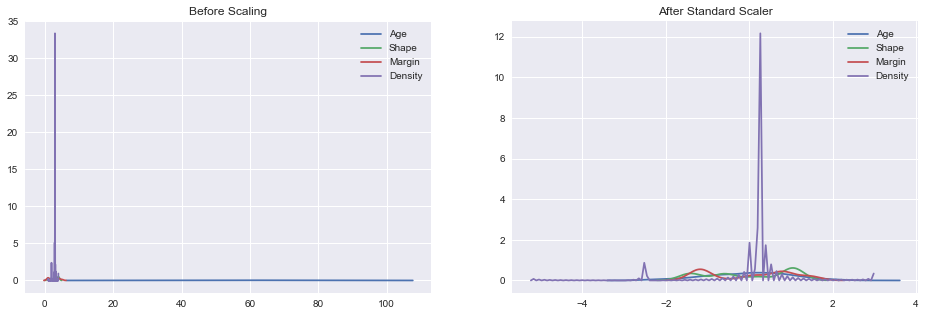

In [10]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_data, columns=['Age', 'Shape', 'Margin', 'Density'])

ax1.set_title('Before Scaling')
sns.kdeplot(df['Age'], ax=ax1)
sns.kdeplot(df['Shape'], ax=ax1)
sns.kdeplot(df['Margin'], ax=ax1)
sns.kdeplot(df['Density'], ax=ax1)
ax2.set_title('After Standard Scaler')
sns.kdeplot(scaled_df['Age'], ax=ax2)
sns.kdeplot(scaled_df['Shape'], ax=ax2)
sns.kdeplot(scaled_df['Margin'], ax=ax2)
sns.kdeplot(scaled_df['Density'], ax=ax2)
plt.show()

### Do a Train Test split for the scaled data
Before moving on a train/test split of the  data is needed. 75% is set aside for training, and 25% for testing.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_data,y, test_size=0.25, random_state=42)

## Decision Tree

In [13]:
from sklearn import tree
y = df['Severity'] #this is what we're trying to predict!
X = df[features]
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(X_train, y_train)

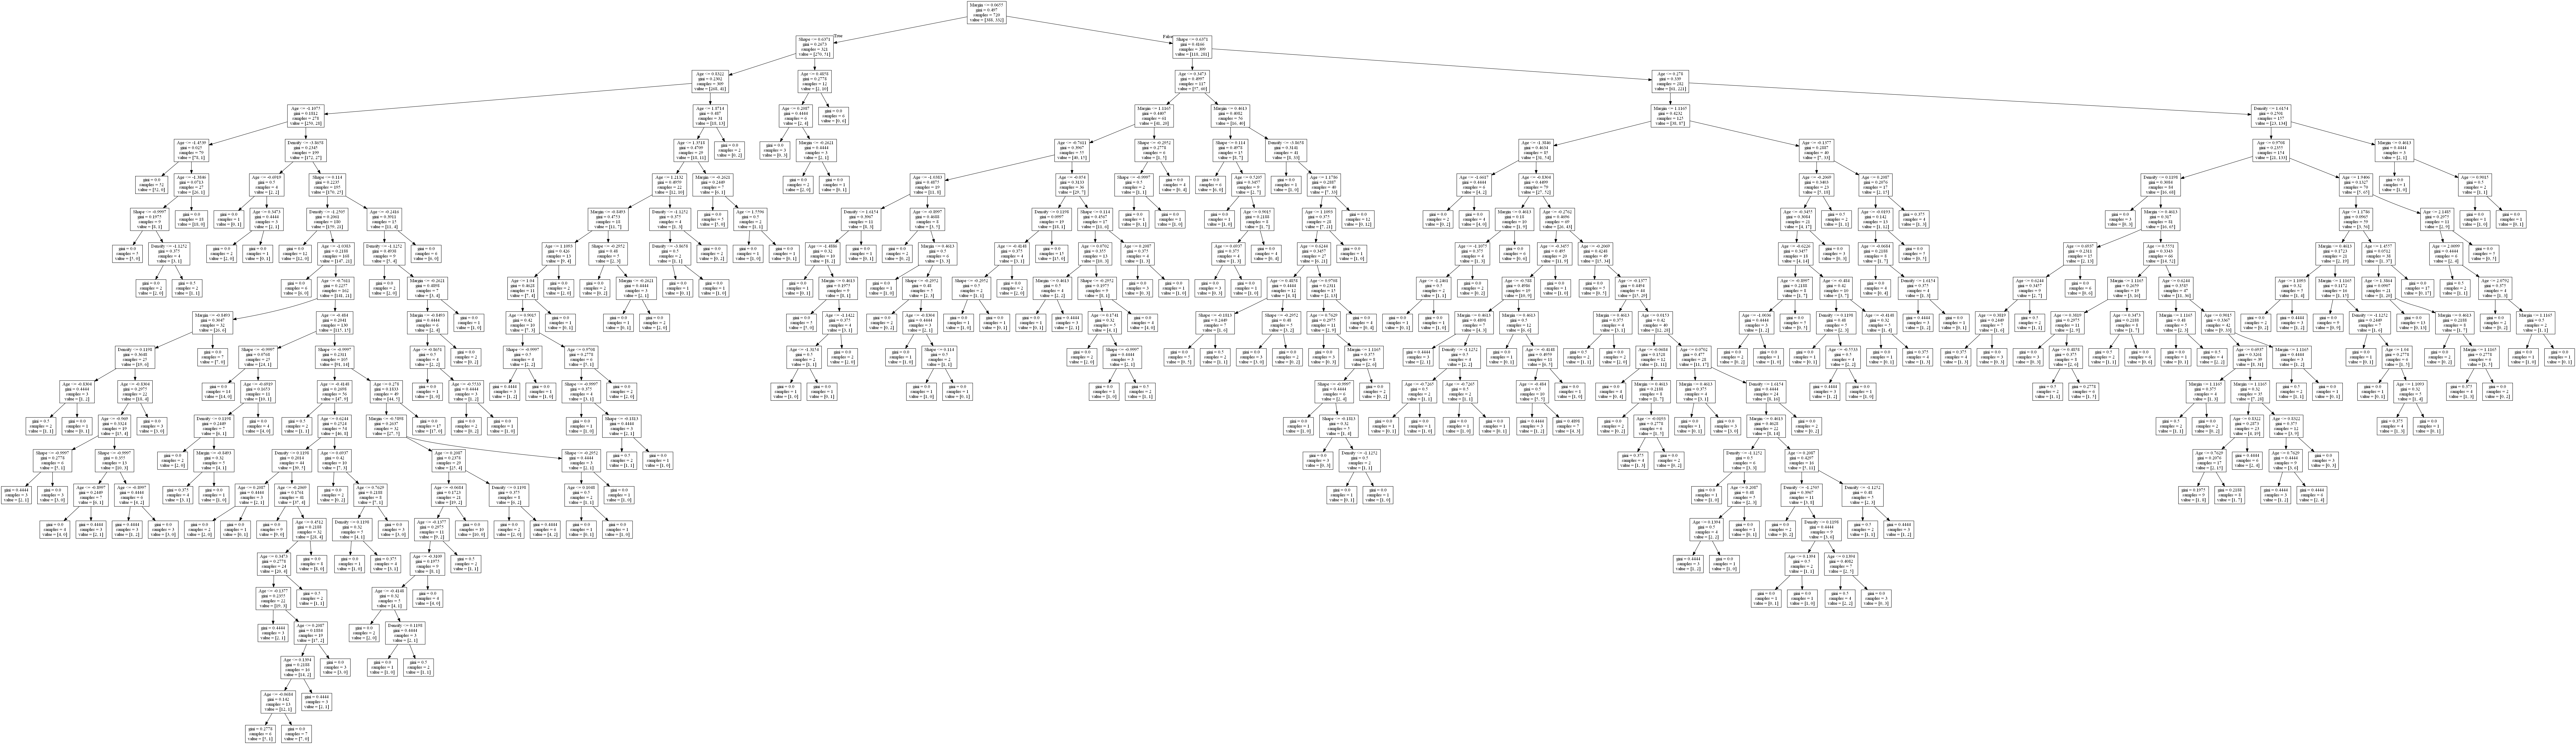

In [14]:
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image
dot_data = StringIO()  
tree.export_graphviz(dtc, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png()) 

### Checking the accuracy including a Classification Report and Confusion Matrix 

In [15]:
dtc_pred = dtc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,dtc_pred))

             precision    recall  f1-score   support

          0       0.77      0.77      0.77       128
          1       0.74      0.73      0.74       113

avg / total       0.76      0.76      0.76       241



In [16]:
print(confusion_matrix(y_test,dtc_pred))

[[99 29]
 [30 83]]


In [17]:
from sklearn.metrics import accuracy_score
accuracy_score( y_test, dtc_pred)

0.7551867219917012

#### Accuracy after cross validation

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dtc,  X_train, y_train, cv=10)

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores) 

Scores: [0.65753425 0.5890411  0.83333333 0.70833333 0.76388889 0.75
 0.75       0.76388889 0.67605634 0.73239437]
Mean: 0.7224470491135551
Standard deviation: 0.06458329107062878


#### Accuracy after cross validation - same as with the   *def display_score*   above

In [20]:
dtc_cv = cross_val_score(dtc, X_train, y_train, cv=10)
dtc_cv.mean()

0.7224666109288914

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier 
forest_reg = RandomForestClassifier(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### Checking the accuracy including a Classification Report and Confusion Matrix 

In [22]:
forest_reg_pred = forest_reg.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,forest_reg_pred))

             precision    recall  f1-score   support

          0       0.76      0.78      0.77       128
          1       0.75      0.73      0.74       113

avg / total       0.75      0.76      0.75       241



In [23]:
print(confusion_matrix(y_test,forest_reg_pred))

[[100  28]
 [ 31  82]]


In [24]:
from sklearn.metrics import accuracy_score
accuracy_score( y_test, forest_reg_pred)

0.7551867219917012

#### Accuracy after cross validation

In [25]:
forest_reg_cv = cross_val_score(forest_reg, X_train, y_train, cv=10)
print(forest_reg_cv.mean())

0.7487815400776041


## SVM - with different kernels
### kernel  'linear'

In [26]:
from sklearn.svm import SVC
svm_linear = SVC( kernel = 'linear')
svm_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
svm_linear_pred = svm_linear.predict(X_test)

#### Accuracy for 'linear' with test set

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_linear_pred)

0.8215767634854771

#### Accuracy for 'linear' after cross validation

In [29]:
svm_linear_cv = cross_val_score(svm_linear, X_train, y_train, cv=10)
print(svm_linear_cv.mean())

0.7805183077153943


### kernel = 'rbf'

In [30]:
from sklearn.svm import SVC
svm_rbf = SVC( kernel = 'rbf')
svm_rbf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
svm_rbf_pred = svm_rbf.predict(X_test)

#### Accuracy for 'rbf' with test set

In [32]:
#from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_rbf_pred)

0.8091286307053942

#### Accuracy for 'rbf' after cross validation

In [33]:
svm_rbf_cv = cross_val_score(svm_rbf, X_train, y_train, cv=10)
print(svm_rbf_cv.mean())

0.7861145947220616


### kernel = 'sigmoid'

In [34]:
from sklearn.svm import SVC
svm_sigmoid = SVC( kernel = 'sigmoid')  
svm_sigmoid.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
svm_sigmoid_pred = svm_sigmoid.predict(X_test)

#### Accuracy for 'sigmoid' with test set

In [36]:
#from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_sigmoid_pred)

0.7427385892116183

#### Accuracy for 'sigmoid' after cross validation

In [37]:
svm_sigmoid_cv = cross_val_score(svm_sigmoid, X_train, y_train, cv=10)
print(svm_sigmoid_cv.mean())

0.7276400411602032


### kernel = 'poly'

In [38]:
from sklearn.svm import SVC
svm_poly = SVC( kernel = 'poly', degree=3)  
svm_poly.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
svm_poly_pred = svm_poly.predict(X_test)

#### Accuracy for 'poly' with test set

In [40]:
#from sklearn.metrics import accuracy_score
accuracy_score(y_test, svm_poly_pred) # degree=3 : 0.76470588 d=2 : 0.7986193 d=4 : 0.77731 d=1 : 0.802521

0.8049792531120332

#### Accuracy for 'poly' after cross validation

In [41]:
svm_poly_cv = cross_val_score(svm_poly, X_train, y_train, cv=10)
print(svm_poly_cv.mean())

0.7957416875683324


## KNN - K-Nearest-Neighbors

In [42]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train) 
neigh_pred = neigh.predict(X_test)

Choosing K is tricky, so I do this using a loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. 

In [43]:
for K in range(50):
    K_value = K+1
    neigh = KNeighborsClassifier(n_neighbors = K_value, weights='uniform', algorithm='auto')
    neigh.fit(X_train, y_train)
    neigh_pred = neigh.predict(X_test)
    print ("Accuracy is ", accuracy_score(y_test,neigh_pred)*100,"% for K-Value:",K_value)

Accuracy is  74.27385892116183 % for K-Value: 1
Accuracy is  71.78423236514523 % for K-Value: 2
Accuracy is  80.49792531120332 % for K-Value: 3
Accuracy is  77.59336099585063 % for K-Value: 4
Accuracy is  80.91286307053942 % for K-Value: 5
Accuracy is  79.25311203319502 % for K-Value: 6
Accuracy is  78.83817427385893 % for K-Value: 7
Accuracy is  79.25311203319502 % for K-Value: 8
Accuracy is  79.66804979253112 % for K-Value: 9
Accuracy is  78.00829875518673 % for K-Value: 10
Accuracy is  78.42323651452283 % for K-Value: 11
Accuracy is  77.59336099585063 % for K-Value: 12
Accuracy is  78.42323651452283 % for K-Value: 13
Accuracy is  79.25311203319502 % for K-Value: 14
Accuracy is  80.08298755186722 % for K-Value: 15
Accuracy is  79.25311203319502 % for K-Value: 16
Accuracy is  80.08298755186722 % for K-Value: 17
Accuracy is  79.66804979253112 % for K-Value: 18
Accuracy is  80.49792531120332 % for K-Value: 19
Accuracy is  80.49792531120332 % for K-Value: 20
Accuracy is  81.3278008298755

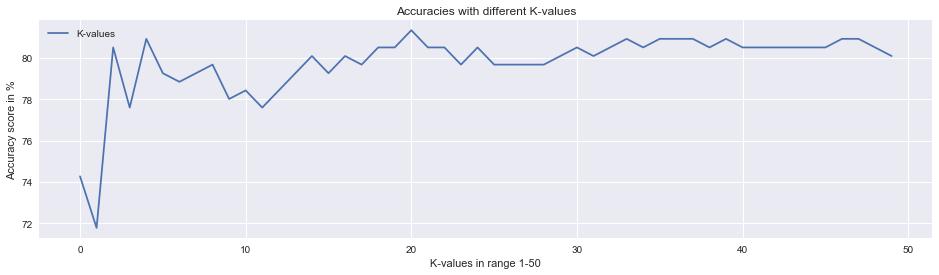

In [70]:
k_values = [74.27385892116183,71.78423236514523,80.49792531120332,77.59336099585063,80.91286307053942,79.25311203319502,78.83817427385893,79.25311203319502,79.66804979253112,78.00829875518673,78.42323651452283,77.59336099585063,78.42323651452283,79.25311203319502,80.08298755186722,79.25311203319502,80.08298755186722,79.66804979253112,80.49792531120332,80.49792531120332,81.32780082987551,80.49792531120332,80.49792531120332,79.66804979253112,80.49792531120332,79.66804979253112,79.66804979253112,79.66804979253112,79.66804979253112,80.08298755186722,80.49792531120332,80.08298755186722,80.49792531120332,80.91286307053942,80.49792531120332,80.91286307053942,80.91286307053942,80.91286307053942,80.49792531120332,80.91286307053942,80.49792531120332,80.49792531120332,80.49792531120332,80.49792531120332,80.49792531120332,80.49792531120332,80.91286307053942,80.91286307053942,80.49792531120332,80.08298755186722]

plt.plot(k_values)
plt.legend(['K-values'], loc=2)
plt.xlabel('K-values in range 1-50')
plt.ylabel('Accuracy score in %')
plt.title('Accuracies with different K-values')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] =16
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.grid(True)
plt.show();

The highest accuracy is reached with K = 21.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train, y_train) 
neigh_pred = neigh.predict(X_test)

### Checking the accuracy including a Classification Report and Confusion Matrix 

In [72]:
print(classification_report(neigh_pred, y_test))

             precision    recall  f1-score   support

          0       0.83      0.82      0.82       129
          1       0.80      0.80      0.80       112

avg / total       0.81      0.81      0.81       241



In [73]:
print(confusion_matrix(neigh_pred, y_test))

[[106  23]
 [ 22  90]]


In [74]:
from sklearn.metrics import accuracy_score
accuracy_score( y_test, neigh_pred)

0.8132780082987552

The **accuracy score** is also equal to 1 - MSE:

In [75]:
# Get the actual values for the test set.
#actual = y_test 
mse = (((neigh_pred - y_test) ** 2).sum()) / len(neigh_pred)
print(1 - mse) 

0.8132780082987552


#### Accuracy after cross validation 

In [76]:
neigh_cv = cross_val_score(neigh, X_train, y_train, cv=10)
print(neigh_cv.mean()) #cv=10:0.77556 cv=50:0.77891

0.7845903809462559


## Naive Bayes

Please note! A MinMaxScaler is needed to get the features in the range MultinomialNB requires.

In [77]:
from sklearn.naive_bayes import MultinomialNB

In [78]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler() 
X_minmax = scaler.fit_transform(X)

mnb = MultinomialNB()

#### To make a Classification Report and Confusion Matrix and checking for Accuracy, the MinMaxScaled data needs to be split into train and test

In [79]:
X_train_MinMax, X_test_MinMax, y_train, y_test = train_test_split(X_minmax,y, test_size=0.25, random_state=42)

In [80]:
mnb.fit(X_train_MinMax, y_train)
mnb_pred = mnb.predict(X_test_MinMax)

### Checking the accuracy including a Classification Report and Confusion Matrix 

In [81]:
print(classification_report(mnb_pred,y_test))

             precision    recall  f1-score   support

          0       0.83      0.76      0.79       139
          1       0.71      0.78      0.74       102

avg / total       0.78      0.77      0.77       241



In [82]:
print(confusion_matrix(y_test, mnb_pred))

[[106  22]
 [ 33  80]]


In [83]:
accuracy_score( y_test, mnb_pred)

0.7717842323651453

#### Accuracy after cross validation

In [84]:
mnb_cv = cross_val_score(mnb, X_minmax, y, cv=10)
print(mnb_cv.mean())

0.7502033595586906


## Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression

In [86]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
logreg_pred = logreg.predict(X_test)

### Checking the accuracy including a Classification Report and Confusion Matrix 

In [88]:
print(classification_report(logreg_pred,y_test))

             precision    recall  f1-score   support

          0       0.82      0.84      0.83       125
          1       0.82      0.80      0.81       116

avg / total       0.82      0.82      0.82       241



In [89]:
print(confusion_matrix(y_test,logreg_pred))

[[105  23]
 [ 20  93]]


#### Checking the accuracy with test set

In [90]:
from sklearn.metrics import accuracy_score
accuracy_score( y_test, logreg_pred)

0.8215767634854771

#### Accuracy after cross validation

In [91]:
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=10)
print(logreg_cv.mean())
print(logreg_cv.std())

0.7846474585718266
0.04160850835491036


## Neural Networks

Let's see if an artificial neural network can do even better. Using Keras I set up a neural network with 1 binary output neuron.

In [92]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.model_selection import cross_val_score

def create_model():
    model = Sequential()
    #4 feature inputs going into a 32-unit layer 
    model.add(Dense(32, input_dim=4, kernel_initializer='normal', activation='relu'))
    # A hidden layer of 16 units
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier

# Wrapping the Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(build_fn=create_model, nb_epoch=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
cv_scores = cross_val_score(estimator, X_train, y_train, cv=10)
print(cv_scores.mean())


0.7777777777777778


## Do we have a winner?

Below the mean accuracies for each model using a 10-fold cross validation. There wasn't a clear winner but the best ones reach roughly an 80% accuracy, which is not too bad with a data set of less than 1000 samples and four features!

In [93]:
print("Decision Tree: \t\t", dtc_cv.mean())
print("Random Forest: \t\t", forest_reg_cv.mean())
print("SVM linear: \t\t", svm_linear_cv.mean())
print("SVM rbf: \t\t", svm_rbf_cv.mean())
print("SVM linear: \t\t", svm_sigmoid_cv.mean())
print("SVM rbf: \t\t", svm_poly_cv.mean())
print("KNN: \t\t\t", neigh_cv.mean())
print("Naive Bayes: \t\t", mnb_cv.mean())
print("Logistic Regression: \t", logreg_cv.mean())
print("Neural Network: \t", cv_scores.mean())

Decision Tree: 		 0.7224666109288914
Random Forest: 		 0.7487815400776041
SVM linear: 		 0.7805183077153943
SVM rbf: 		 0.7861145947220616
SVM linear: 		 0.7276400411602032
SVM rbf: 		 0.7957416875683324
KNN: 			 0.7845903809462559
Naive Bayes: 		 0.7502033595586906
Logistic Regression: 	 0.7846474585718266
Neural Network: 	 0.7777777777777778
